In [9]:
%matplotlib inline

import sys
import logging
import itertools
import copy

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(0)

In [10]:
env = gym.make('MountainCar-v0')

# Вывод информации о переменных среды
env_vars = vars(env)
for key in env_vars:
    print(f"{key}: {env_vars[key]}")

# Вывод информации о переменных спецификации среды
spec_vars = vars(env.spec)
for key in spec_vars:
    print(f"{key}: {spec_vars[key]}")


env: <OrderEnforcing<PassiveEnvChecker<MountainCarEnv<MountainCar-v0>>>>
_action_space: None
_observation_space: None
_reward_range: None
_metadata: None
_max_episode_steps: 200
_elapsed_steps: None
id: MountainCar-v0
entry_point: gym.envs.classic_control.mountain_car:MountainCarEnv
reward_threshold: -110.0
nondeterministic: False
max_episode_steps: 200
order_enforce: True
autoreset: False
disable_env_checker: False
apply_api_compatibility: False
kwargs: {}
namespace: None
name: MountainCar
version: 0


==== train ====
train episode 0: reward = -200.00, steps = 200
train episode 1: reward = -200.00, steps = 200
train episode 2: reward = -200.00, steps = 200
train episode 3: reward = -200.00, steps = 200
train episode 4: reward = -200.00, steps = 200
train episode 5: reward = -200.00, steps = 200
train episode 6: reward = -200.00, steps = 200
train episode 7: reward = -200.00, steps = 200
train episode 8: reward = -200.00, steps = 200
train episode 9: reward = -200.00, steps = 200
train episode 10: reward = -200.00, steps = 200
train episode 11: reward = -200.00, steps = 200
train episode 12: reward = -200.00, steps = 200
train episode 13: reward = -200.00, steps = 200
train episode 14: reward = -200.00, steps = 200
train episode 15: reward = -200.00, steps = 200
train episode 16: reward = -200.00, steps = 200
train episode 17: reward = -200.00, steps = 200
train episode 18: reward = -200.00, steps = 200
train episode 19: reward = -200.00, steps = 200
train episode 20: reward = -200.00

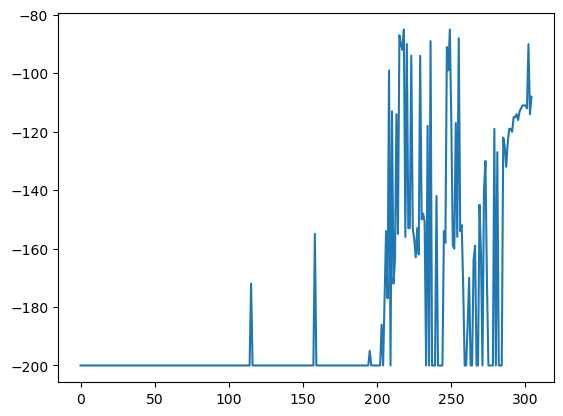

In [11]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'terminated'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = np.asarray(args, dtype=object)
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

class DQNAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.replayer = DQNReplayer(10000)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.evaluate_net = self.build_net(
            input_size=env.observation_space.shape[0],
            hidden_sizes=[64, 64], output_size=self.action_n
        ).to(self.device)
        self.optimizer = optim.Adam(self.evaluate_net.parameters(), lr=0.001)
        self.loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        model = nn.Sequential(*layers).to(self.device)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.target_net = copy.deepcopy(self.evaluate_net)

    def step(self, observation, reward, terminated):
        if self.mode == 'train' and np.random.rand() < 0.001:
            # epsilon-greedy policy in train mode
            action = np.random.randint(self.action_n)
        else:
            state_tensor = torch.as_tensor(observation, dtype=torch.float).squeeze(0).to(self.device)
            q_tensor = self.evaluate_net(state_tensor)
            action_tensor = torch.argmax(q_tensor)
            action = action_tensor.item()
        if self.mode == 'train':
            self.trajectory += [observation, reward, terminated, action]
            if len(self.trajectory) >= 8:
                state, _, _, act, next_state, reward, terminated, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, act, reward, next_state, terminated)
            if self.replayer.count >= self.replayer.capacity * 0.95:
                    # skip first few episodes for speed
                self.learn()
        return action

    def close(self):
        pass

    def learn(self):
        # replay
        states, actions, rewards, next_states, terminateds = \
                self.replayer.sample(1024)
        state_tensor = torch.as_tensor(states, dtype=torch.float).to(self.device)
        action_tensor = torch.as_tensor(actions, dtype=torch.long).to(self.device)
        reward_tensor = torch.as_tensor(rewards, dtype=torch.float).to(self.device)
        next_state_tensor = torch.as_tensor(next_states, dtype=torch.float).to(self.device)
        terminated_tensor = torch.as_tensor(terminateds, dtype=torch.float).to(self.device)

        # update value net
        next_q_tensor = self.target_net(next_state_tensor)
        next_max_q_tensor, _ = next_q_tensor.max(axis=-1)
        target_tensor = reward_tensor + self.gamma * \
                (1. - terminated_tensor) * next_max_q_tensor
        pred_tensor = self.evaluate_net(state_tensor)
        q_tensor = pred_tensor.gather(1, action_tensor.unsqueeze(1)).squeeze(1)
        loss_tensor = self.loss(target_tensor, q_tensor)
        self.optimizer.zero_grad()
        loss_tensor.backward()
        self.optimizer.step()


agent = DQNAgent(env)

def play_episode(env, agent, seed=None, mode=None, render=False):
    observation, _ = env.reset(seed=seed)
    reward, terminated, truncated = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, terminated)
        if render:
            env.render()
        if terminated or truncated:
            break
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
    agent.close()
    return episode_reward, elapsed_steps


print('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env, agent, seed=episode, mode='train')
    episode_rewards.append(episode_reward)
    print(f'train episode {episode}: reward = {episode_reward:.2f}, steps = {elapsed_steps}')
    if np.mean(episode_rewards[-10:]) > -110:
        break
plt.plot(episode_rewards)

print('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    print(f'test episode {episode}: reward = {episode_reward:.2f}, steps = {elapsed_steps}')
print(f'average episode reward = {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}')
